In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import ShapKernel
from sklearn.metrics import confusion_matrix


/var/folders/c5/zyd8z1kn38124wqv1bc05h500000gn/T/ipykernel_14601/1222399003.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(url, names=columns)

# Handle missing values
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
data.fillna(data.mean(), inplace=True)


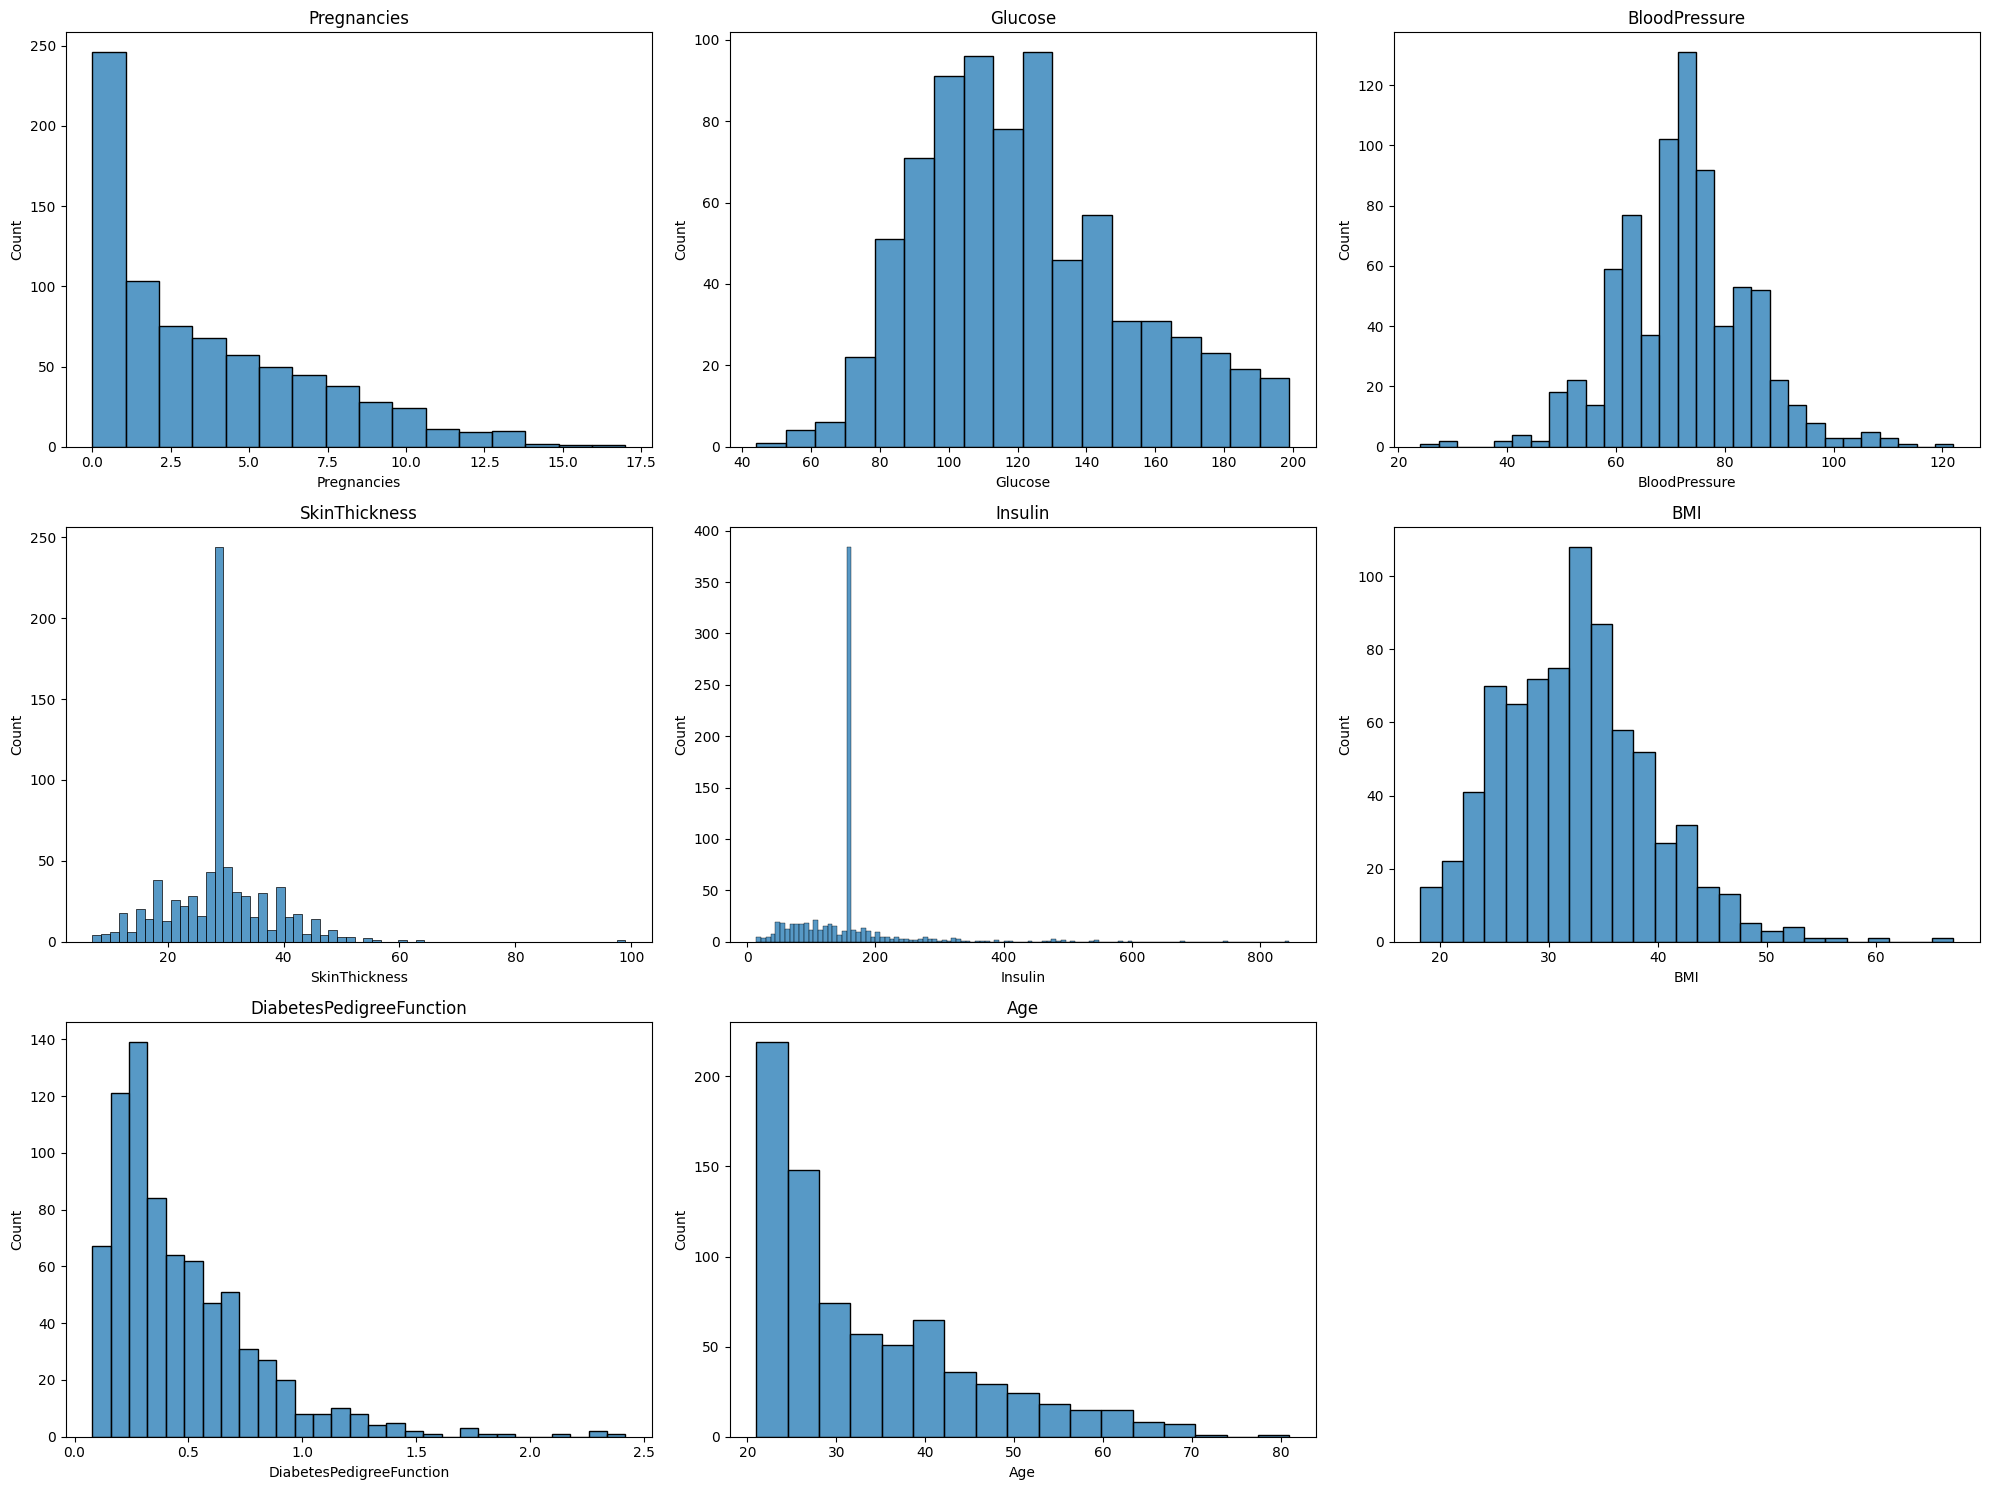

In [4]:


# Exploratory Data Analysis (EDA)
# Distribution of each feature
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column])
    plt.title(column)

plt.tight_layout()
plt.show()



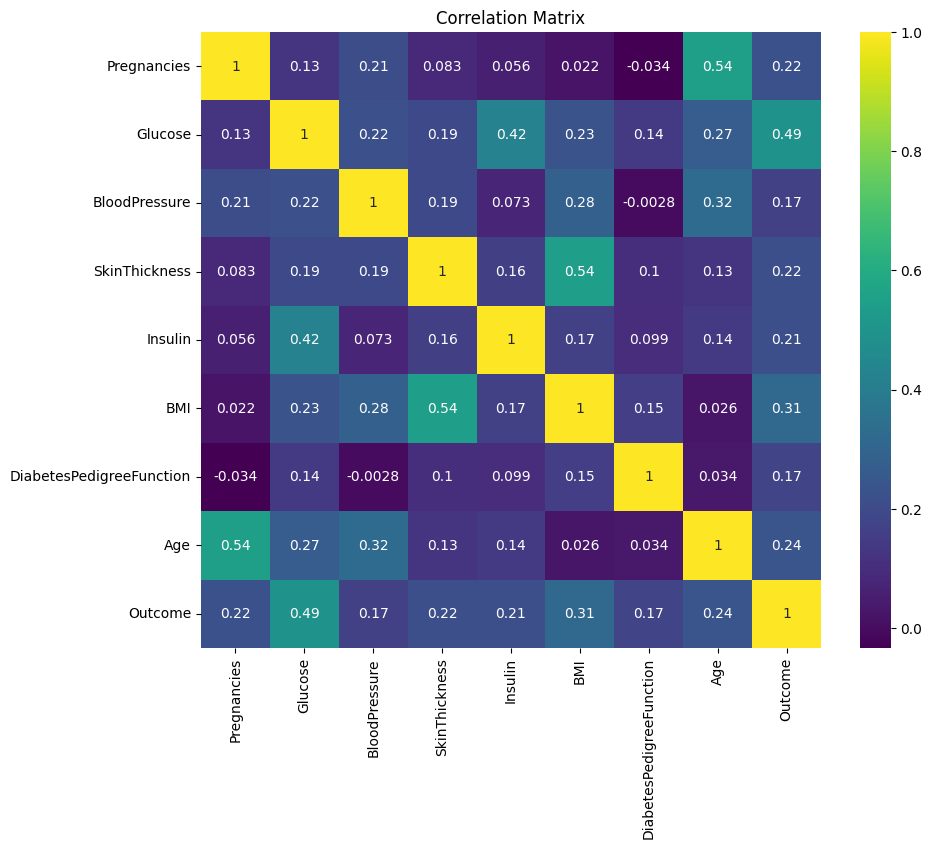

In [5]:

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


In [6]:

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('Outcome', axis=1))
X = pd.DataFrame(scaled_features, columns=columns[:-1])
y = data['Outcome']



In [7]:

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:

# Building the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [9]:

# Evaluating the model
predictions = model.predict(X_test)
print("Initial Model Evaluation:\n")
print(classification_report(y_test, predictions))
initial_accuracy = accuracy_score(y_test, predictions)



Initial Model Evaluation:

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



In [12]:

# Bias Detection with 'Interpret'
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# Global explanation
ebm_global = ebm.explain_global()


In [30]:
# for i in next(ebm_global.data):
#     print(i)

print(ebm_global.data())

{'type': 'univariate', 'names': ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies & Age', 'Glucose & BloodPressure', 'Glucose & Insulin', 'Glucose & BMI', 'Glucose & DiabetesPedigreeFunction', 'Glucose & Age', 'SkinThickness & Age', 'Insulin & Age', 'BMI & Age', 'DiabetesPedigreeFunction & Age'], 'scores': [0.1209185771900994, 0.5711734440713778, 0.09290639985847647, 0.16660077631758438, 0.2627266994215035, 0.44400042722494154, 0.241098746202444, 0.4069663202297491, 0.04139737234786177, 0.051048473182535, 0.06757297536797892, 0.08002802458198457, 0.059453829297754814, 0.061214821493225643, 0.09892934450590461, 0.04723032619403976, 0.04310531417093032, 0.037720887164862466]}


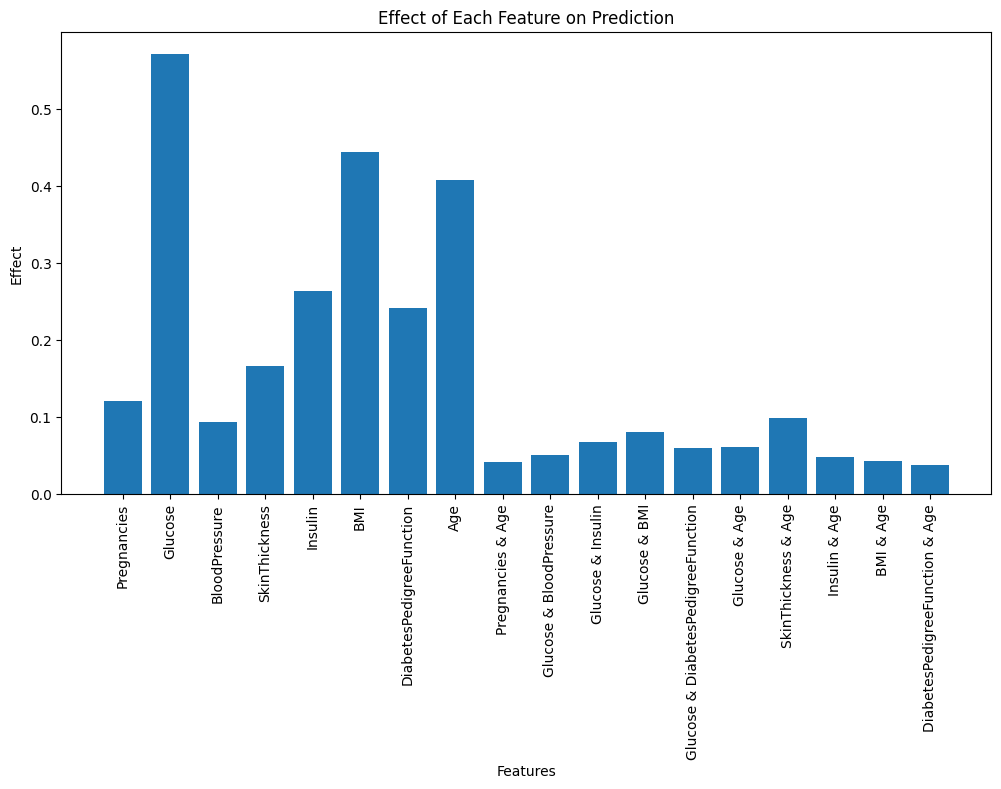

In [37]:
import matplotlib.pyplot as plt

data = ebm_global.data()

# Extracting lists from the dictionary
feature_names = data['names']
feature_scores = data['scores']

# Ensure that feature_names and feature_scores have the same length
assert len(feature_names) == len(feature_scores), "Lengths of names and scores do not match."

# Plotting all feature importances on the same graph
plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_scores)
plt.title("Effect of Each Feature on Prediction")
plt.xlabel("Features")
plt.ylabel("Effect")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.show()


In [38]:
# # Plotting each feature's importance
# for i in range(len(feature_names)):
#     plt.figure()
#     plt.title(f"Effect of {feature_names[i]} on Prediction")
#     plt.bar(feature_names[i], feature_scores[i])
#     plt.ylabel('Effect')
#     plt.show()


In [35]:
# # Corrected approach to plot feature importance from ebm_global
# for feature_data in ebm_global.data():
#     feature_name = feature_data['names']
#     feature_effects = feature_data['scores']
#     feature_values = feature_data['values']

#     plt.figure()
#     plt.title(f"Effect of {feature_name} on Prediction")
#     plt.plot(feature_effects, feature_effects)
#     plt.xlabel(feature_name)
#     plt.ylabel('Effect')
#     plt.show()


In [17]:

# Bias Mitigation and Re-evaluation
# For this example, we might consider equalizing the weight of age groups
# Adjust the weight of younger and older age groups
age_weight = X_train['Age'].apply(lambda x: 1.5 if x < 30 or x > 50 else 1.0)


In [39]:

# Re-train the model
ebm_weighted = ExplainableBoostingClassifier(random_state=42)
ebm_weighted.fit(X_train, y_train, sample_weight=age_weight)


ExplainableBoostingClassifier()

In [40]:


# Re-evaluate the model
weighted_predictions = ebm_weighted.predict(X_test)
print("\nWeighted Model Evaluation:\n")
print(classification_report(y_test, weighted_predictions))
weighted_accuracy = accuracy_score(y_test, weighted_predictions)



Weighted Model Evaluation:

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        99
           1       0.62      0.67      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154



In [41]:



# Comparing initial and weighted model accuracies
print(f"Initial Model Accuracy: {initial_accuracy:.2f}")
print(f"Weighted Model Accuracy: {weighted_accuracy:.2f}")


Initial Model Accuracy: 0.75
Weighted Model Accuracy: 0.73


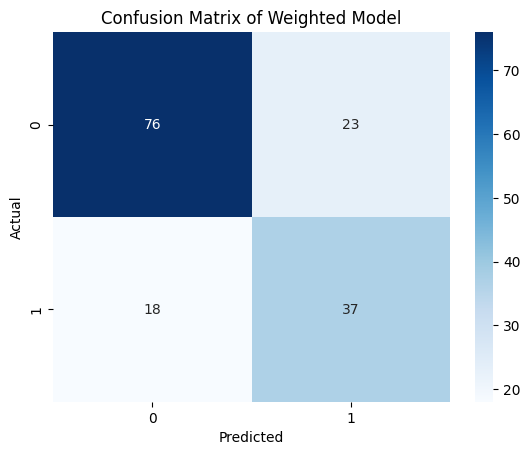

In [42]:

# Visualising the effect of weighting
plt.figure()
sns.heatmap(confusion_matrix(y_test, weighted_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Weighted Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

